In [92]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from auxFunc import entropydensity
from scipy.special import kn, zeta


In [93]:
def Yeq(x):
    #m represents particle's mass, T is temperature in GeV, g represents the particle's degrees of freedom, 
    #and s represents entropy density.
    m = 1.0
    mDM = 1.0
    g = 1.0
    T = mDM/x

    g_star = 20.0 #g_* is the number of relativistic degrees of freedom
    s = entropydensity(x, mDM) #entropy density
    if (m/T)>10: #non-relativistic regime
        Y_eq = (45/(4 * np.pi**4)) * (abs(g)/g_star) * (m/T)**(1.5) * np.sqrt(np.pi/2) * np.exp(-m/T) * (1 + (15/(8 * (m/T))) + 105/(128 * (m/T)**2) - (315/(1024 * (m/T)**3) )) #(abs(g) * (m * T/ (2 * np.pi))**(3/2) * np.exp(-m/T))/s
    if (m/T)>(2/3): #semi-relativistic regime
        Y_eq = ((abs(g)/(2 * np.pi**2)) * ( T * m**2)* kn(2, m/T)/s) #(45 * abs(g) * (m/T)**2 * kn(2,(m/T)))/(4 * np.pi**4 * g_star)
    elif (m/T)<=(2/3): #relativistic regime
        if g > 0: #fermions
           Y_eq = ((3/4) * (zeta(3)/np.pi**2) * abs(g) * (T)**3)/s
        if g < 0: #bosons
            Y_eq = ((zeta(3)/np.pi**2) * abs(g) * (T)**3)/s
    return Y_eq

def F(x):

    return 1e3/x**2

def dYeqdx(x):

    dx = 1e-2
    return (Yeq(x+dx)-Yeq(x))/dx

def dFdx(x):

    return (-2/x**3)*F(1)

def YtoG(Y,x):
    f = F(x)
    t1 = f/(1+f)
    return Y - Yeq(x)*t1

def GtoY(G,x):
    f = F(x)
    return G + Yeq(x)*(1-1/(1+f))

def dYdx(Y,x):

    f = F(x)
    
    return f*(Yeq(x)**2 - Y**2)



In [94]:
def dGdx(G,x):

    f = F(x)
    t0 = 1/(1+f)
    t1 = f*t0
    t12 = f*t0**2
     
    yeq = Yeq(x)
    
    fg = f*G

    d = -fg*G -2*fg*yeq + 2*t1*G*yeq + (2*t1-t12)*yeq**2 - t0**2*yeq*dFdx(x) - dYeqdx(x)*(t0-1) 

    return d

In [99]:
x0 = 0.5
Y0 = Yeq(x0)
G0 = YtoG(Y0,x0)
xvals = np.linspace(x0,10.,10000)

print(Yeq(x0),F(x0),dYeqdx(x0),dFdx(x0),G0,dGdx(G0,x0))

0.0019507491838281288 4000.0 2.168404344971009e-17 -16000.0 4.87565404605917e-07 1.949774174900917e-06


In [100]:
G_sol = odeint(dGdx,G0,xvals)
Y_sol0 = odeint(dYdx,Y0,xvals)

In [101]:
Y_sol = [GtoY(G,x) for G,x in zip(G_sol,xvals)]
Y_eq = [Yeq(x) for x in xvals]
dGdx_sol = [dGdx(G,x) for G,x in zip(G_sol,xvals)]
dYdx_sol = [dYdx(Y,x) for Y,x in zip(Y_sol0,xvals)]

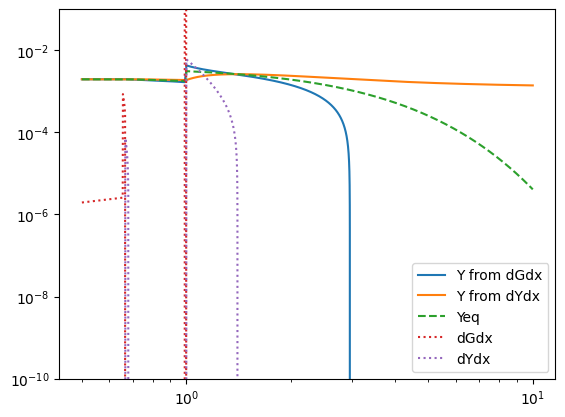

In [102]:
plt.plot(xvals,Y_sol,label='Y from dGdx')
plt.plot(xvals,Y_sol0,label='Y from dYdx')
plt.plot(xvals,Y_eq,linestyle='dashed',label='Yeq')
plt.plot(xvals,dGdx_sol,linestyle='dotted',label='dGdx')
plt.plot(xvals,dYdx_sol,linestyle='dotted',label='dYdx')

plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-10,1e-1)
plt.show()